# Imports and Installs

In [1]:
from google.colab import drive
drive.mount('/content/drive')
!pip install spacy==3.1.4
!python -m spacy download de_core_news_md
!python -m spacy download en_core_web_sm
!pip install datasets transformers seqeval
!pip install -q iterative-stratification
!pip install pandas-ods-reader
!pip install weasyprint==52.5 
!pip install pdf2image
!apt-get install poppler-utils
!pip install pyyaml==5.4.1 # plotly bug

%load_ext autoreload
%autoreload 2

Mounted at /content/drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.9 MB 12.3 MB/s 
     |████████████████████████████████| 10.1 MB 2.6 MB/s 
     |████████████████████████████████| 660 kB 44.4 MB/s 
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.1.1
    Uninstalling typing-extensions-4.1.1:
      Successfully uninstalled typing-extensions-4.1.1
  Attempting uninstall: pydantic
    Found existing installation: pydantic 1.9.2
    Uninstalling pydantic-1.9.2:
      Successfully uninstalled pydantic-1.9.2
  Attempting uninstall: thinc
    Found existing installation: thinc 8.1.0
    Uninstalling thinc-8.1.0:
      Successfully uninstalled thinc-8.1.0
  Attempting uninstall: spacy
    Found existing installation: spacy 3.4.1
    Uninstalling spacy-3.4.1:
      Successfully uninstalled spacy-3.4.1
ERROR: pip's dependency resolver does not current

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 47.8 MB 1.6 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_md')
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.6 MB 9.9 MB/s 
  Attempting uninstall: en-core-web-sm
    Found existing installation: en-core-web-sm 3.4.0
    Uninstalling en-core-web-sm-3.4.0:
      Successfully uninstalled en-core-web-sm-3.4.0
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 365 kB 12.7 MB/s 
     |████████████████████████████████| 4.7 MB 44.9 MB/s 
     |████████████████████████████████| 43 kB 1.5 MB/s 
     |██████████████████████

In [2]:
import datetime
import functools
import itertools
import joblib
import json
import os
import pickle
import re
import sys
from collections import defaultdict

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import spacy
import torch
from datasets import Dataset, DatasetDict, load_dataset, load_metric
from IPython.core.display import HTML as jupyter_HTML
from IPython.core.display import display as display_html
from pdf2image import convert_from_path
from plotly.subplots import make_subplots
import seaborn as sns

from sklearn.model_selection import KFold, train_test_split
from torch.utils.data import DataLoader
from tqdm import tqdm
from tqdm.auto import tqdm
from transformers import (AutoModel, AutoModelForTokenClassification,
                          AutoTokenizer, BertForMaskedLM, BertTokenizer,
                          DataCollatorForTokenClassification, Trainer,
                          TrainingArguments, get_scheduler)
from weasyprint import CSS, HTML


pd.plotting.backend = "plotly"
pd.set_option('display.max_columns', None)
plt.rcParams.update({'font.size': 20})
tqdm.pandas()


In [3]:
PROJECT_PATH = "/content/drive/My Drive/master thesis/"
FONDSFORSTE_DATSET_PATH = "/content/drive/My Drive/master thesis/data/fondsforste/"
FORSTVERMESSUNG_DATSET_PATH = "/content/drive/My Drive/master thesis/data/forstvermessung/"
REHBEIN_DATA_PATH = "/content/drive/My Drive/master thesis/data/causal_language_DE_release1.0/"
DUNIETZ_DATA_PATH = "/content/drive/My Drive/master thesis/data/BECAUSE/"
ALFZ_DATA_PATH = "/content/drive/My Drive/master thesis/data/ALFZ/"
CURRENT_TIME = datetime.datetime.now().strftime('%Y_%m_%d_%H%M')

sys.path.append(PROJECT_PATH + "code/historic/")

from helper_functions import *
from model import *
from metrics import *
from visualization import *
from training_utils import *

In [4]:
!nvidia-smi

Sun Aug 28 16:32:17 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    29W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Params and Config

In [5]:
causal_arguments = ["Cause", "Effect", "Affected", "Actor", "Controlling", "Support", "Trigger"]

entity_options = {
    'colors': {
        'Cause': '#99FCE0',
        'Effect': '#6779CB',
        'Affected': '#84F72D',
        'Actor': '#108482',
        'Controlling': '#E3AF32',
        'Support': '#C44C6D',
        'Trigger': '#C5E95E',
    },
    'ents': causal_arguments
}

config = {
    "seed": 42,
    "test_size": 0.2,
    "val_size": 0.1,
    "results_directory": PROJECT_PATH + f"output/{CURRENT_TIME}/",
    "rehbein_model_file_path": PROJECT_PATH + "models/pretrained/CBERT_rehbein",
    "dunietz_model_file_path": PROJECT_PATH + "models/pretrained/CBERT_dunietz",
    "rehbein_dunietz_model_file_path": PROJECT_PATH + "models/pretrained/CBERT_rehbein_dunietz",
    "fondsforste_forstvermessung_rehbein_dunietz_model_file_path": PROJECT_PATH + "models/pretrained/CBERT_fondsforste_forstvermessung_rehbein_dunietz",
    "retrain_pretrained": False,
    "model_checkpoints": [
                        #   "dbmdz/bert-base-german-uncased", 
                          "dbmdz/bert-base-german-cased",
                          "dbmdz/bert-base-german-europeana-cased",
                          "bert-base-multilingual-cased",
    ],
    "batch_size": 2,
    "max_length": 500,
    "num_epochs": 75,
    "learning_rate": 2.5e-5,
    "bert_embedding_size": 768,
    "bert_dropout": 0.1,
    "early_stop_patience": 5,
    "causal_arguments": causal_arguments,
    "nlp_ger": spacy.load('de_core_news_md'),
    "nlp_eng": spacy.load("en_core_web_sm"),
    "entity_options": entity_options,
    "val_epochs": 5,
    "add_coreference": False,
    "debug": False,
    "time": CURRENT_TIME,
    "use_normalized": False,
    "warmup_steps": 1000,
}
    
if config["debug"]:
    config["num_epochs"] = 1
    config["model_checkpoints"] = config["model_checkpoints"][:1]
    config["results_directory"] = config["results_directory"][:-1] + "_debug/"
    config["rehbein_model_file_path"] = config["rehbein_model_file_path"] + "_debug"
    config["dunietz_model_file_path"] = config["dunietz_model_file_path"] + "_debug"
    config["rehbein_dunietz_model_file_path"] = config["rehbein_dunietz_model_file_path"] + "_debug"
    config["fondsforste_forstvermessung_rehbein_dunietz_model_file_path"] = config["fondsforste_forstvermessung_rehbein_dunietz_model_file_path"] + "_debug"

try:
    os.mkdir(config["results_directory"])
except:
    print(f"Model directory {config['results_directory']} already created")

config["label_dict"] = {
    'B-Trigger': 0,
    'O': 1, # "Trigger" and "O" 012 so that Trigger-Detection task is automatically aligned
    'B-Actor': 2,
    'I-Actor': 3,
    'B-Affected': 4,
    'I-Affected': 5,
    'B-Cause': 6,
    'I-Cause': 7,
    'B-Controlling': 8,
    'I-Controlling': 9,
    'B-Effect': 10,
    'I-Effect': 11,
    'B-Support': 12,
    'I-Support': 13,
}

config["type_dict"] = {
    "Purpose": 0,
    "Motivation": 1,
    "Consequence": 2,
    "None": 3,
}

config["degree_dict"] = {
    "Facilitate": 0,
    "Inhibit": 1,
    "None": 2,
}

config["label_list"] = list(config["label_dict"].keys())
config["type_list"] = list(config["type_dict"].keys())
config["degree_list"] = list(config["degree_dict"].keys())

config["strict_metric"] = load_metric("seqeval")
config["device"] = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

print(config)

{'seed': 42, 'test_size': 0.2, 'val_size': 0.1, 'results_directory': '/content/drive/My Drive/master thesis/output/2022_08_28_1632/', 'rehbein_model_file_path': '/content/drive/My Drive/master thesis/models/pretrained/CBERT_rehbein', 'dunietz_model_file_path': '/content/drive/My Drive/master thesis/models/pretrained/CBERT_dunietz', 'rehbein_dunietz_model_file_path': '/content/drive/My Drive/master thesis/models/pretrained/CBERT_rehbein_dunietz', 'fondsforste_forstvermessung_rehbein_dunietz_model_file_path': '/content/drive/My Drive/master thesis/models/pretrained/CBERT_fondsforste_forstvermessung_rehbein_dunietz', 'retrain_pretrained': False, 'model_checkpoints': ['dbmdz/bert-base-german-cased', 'dbmdz/bert-base-german-europeana-cased', 'bert-base-multilingual-cased'], 'batch_size': 2, 'max_length': 500, 'num_epochs': 75, 'learning_rate': 2.5e-05, 'bert_embedding_size': 768, 'bert_dropout': 0.1, 'early_stop_patience': 5, 'causal_arguments': ['Cause', 'Effect', 'Affected', 'Actor', 'Con

# Demo with single example annotations

# Practical Experiment

In [6]:
!sudo apt install tesseract-ocr
!sudo apt-get install tesseract-ocr-deu
!pip install pytesseract
!pip install PyMuPDF
import fitz
from PIL import Image
import pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 20 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 1s (4,875 kB/s)
debconf: unable to initi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 8.8 MB 8.9 MB/s 


## Load Model

In [7]:
# Sanity checks
model = CBERT(config["model_checkpoints"][0], config)
model_path = "/content/drive/MyDrive/master thesis/models/pretrained/CBERT_fondsforste_forstvermessung_rehbein_dunietz_dbmdz_bert-base-german-cased.pth"
model.load_state_dict(torch.load(model_path))
model.to(config["device"])
tokenizer = AutoTokenizer.from_pretrained(config["model_checkpoints"][0])

[autoreload of PIL.Image failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/usr/local/lib/python3.7/dist-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/usr/lib/python3.7/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/usr/lib/python3.7/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 630, in _exec
  File "<frozen importlib._bootstrap_external>", line 728, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/usr/local/lib/python3.7/dist-packages/PIL/Image.py", line 53, in <module>
    from ._util import DeferredError, is_path
ImportError: cannot import name 'DeferredError' from 'PIL._util' (/usr/local/lib/python3.7/dist-packages/PIL/_ut

Some weights of the model checkpoint at dbmdz/bert-base-german-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Get Data

In [8]:
import requests




In [28]:
if os.path.exists(ALFZ_DATA_PATH + f'historic_data.pkl'):
    print("Data already downloaded")
    historic_data = joblib.load(ALFZ_DATA_PATH + f'historic_data.pkl')
else:
    historic_data = {}
    years = list(range(1851, 1867+1))

    for year in tqdm(years):

        print("Year", year)
        collection_url = f"https://iiif.onb.ac.at/presentation/collection/alf_{year}"
        collection = json.loads(requests.get(collection_url).text)

        for manifest in collection["manifests"]:
            print(manifest["label"])

            issue_data = json.loads(requests.get(manifest["@id"]).text)

            # print(issue_data["label"])

            texts= []
            for page in tqdm(issue_data["sequences"][0]["canvases"]):
                json_ocr = json.loads(requests.get(page["otherContent"][0]["@id"]).text)

                text = ""
                for line_data in json_ocr["resources"]:
                    text += " " + line_data["resource"]["chars"]
                
                texts.append(text)

            historic_data[manifest["label"]] = {"raw_texts": texts}

        #     break # single issue
        # break # only single year

    for issue_date, issue_data in tqdm(historic_data.items()):

        print(issue_date)

        issue_results = []
        for page_num, text in enumerate(issue_data["raw_texts"]):

            if not text: continue

            sentences = [sent.text for sent in config["nlp_ger"](text.replace("\n", " ")).sents]
            # print(sentences)

            results = []
            for i, sentence in enumerate(sentences):
                try:
                    sent_results = annotate_single_sentence(model, sentence, tokenizer, config)
                except:
                    print(f"Error with sentence: {sentence}")
                    continue

                sent_results["id"] = i
                sent_results["sent_before"] = sentences[i-1] if i > 1 else ""
                sent_results["sent_after"] = sentences[i+1] if i < (len(sentences)-1) else ""
                sent_results["id"] = i
                results.append(sent_results)

            results = pd.concat(results)
            results = results[results["labels"].map(lambda l: ("B-Cause" in l) and ("B-Effect" in l))]

            # display(results)

            results["page_num"] = page_num
            issue_results.append(results)

        if issue_results:
            historic_data[issue_date]["issue_results"] = pd.concat(issue_results).reset_index().to_dict()
        else:
            historic_data[issue_date]["issue_results"] = {}

    joblib.dump(historic_data, ALFZ_DATA_PATH + f'historic_data.pkl')

Data already downloaded


In [29]:
issue_results = []
for issue_name in historic_data.keys():
    res_data = pd.DataFrame(historic_data[issue_name]['issue_results'])
    res_data["issue_name"] = re.search("(\d\d\d\d-\d\d-\d\d)|(\d\d\d\d)", issue_name)[0]
    issue_results.append(res_data)

issue_results = pd.concat(issue_results).reset_index()
issue_results

,level_0,index,tokens,labels,kind,type,degree,relation_id,id,sent_before,sent_after,page_num,issue_name
0,0,0.0,"[I, Nedinanisse, der, Pränumeration, :, für, W...","[O, B-Effect, I-Effect, I-Effect, O, B-Effect,...",Predicted,Purpose,Facilitate,0.0,15.0,V,45 kr.,0.0,1851-07-05
1,1,0.0,"[E., M.^, ohne, Beiblatt, rierteUSbriq, l, «, ...","[O, O, B-Trigger, B-Cause, B-Effect, I-Effect,...",Predicted,Consequence,Inhibit,0.0,21.0,C. M„ mit Beiblatt vierteljährig I 5. 24 kr.,«,0.0,1851-07-05
2,2,0.0,"[Für, Auswärtige, mit, Zuscnduug, rr, ., Post,...","[O, B-Cause, B-Trigger, B-Cause, I-Cause, I-Ca...",Predicted,Consequence,Facilitate,0.0,24.0,s. M. —,io,0.0,1851-07-05
3,3,0.0,"[M, .., ohne, Beiblatt, », ierteljäbrig, 1, .,...","[O, O, B-Trigger, B-Cause, O, B-Effect, O, O, ...",Predicted,Consequence,Inhibit,0.0,32.0,c>.,15 kr.,0.0,1851-07-05
4,4,0.0,"[Für, die, dreimal, gesraltene, P, -, tilzeile...","[B-Trigger, B-Effect, I-Effect, I-Effect, I-Ef...",Predicted,Purpose,Facilitate,0.0,35.0,C. M. — Einrückungs-Gebühr:,s>.,0.0,1851-07-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...
171294,168,0.0,"[1080, ,, 1, ., Spalte, wäre, bei, „, Bindet, ...","[O, O, O, O, O, O, O, O, B-Cause, I-Cause, I-C...",Predicted,Consequence,Facilitate,0.0,204.0,"1078 , 2. Spalte, 6. Zeile von unten, lies sta...",Nach dieser Vor aussetzung wäre die Bittererde...,14.0,1867-12-27
171295,169,0.0,"[Nach, dieser, Vor, aussetzung, wäre, die, Bit...","[O, O, O, O, B-Effect, I-Effect, I-Effect, O, ...",Predicted,Consequence,Facilitate,0.0,205.0,"1080, 1. Spalte wäre bei „Bindet man diese an ...",xsx.,14.0,1867-12-27
171296,170,0.0,"[IS, ,, Spore, », fiir, Narto, ,, bei, der, Gü...","[O, O, O, O, B-Trigger, B-Cause, O, O, O, O, O...",Predicted,Purpose,Facilitate,0.0,4.0,fl.,In 1>V.,15.0,1867-12-27
171297,171,0.0,"[Kerausgegeben, durch, das, k., k., österreich...","[B-Effect, B-Trigger, B-Cause, I-Cause, I-Caus...",Predicted,Consequence,Facilitate,0.0,9.0,u Paris,3. Lieferung.,15.0,1867-12-27


# Whoosh

- search for different causal arguments
- visualize results
- control number of results
- filter only good relations
- wrap in interface?

## Filter results 
- less than 5 tokens
- only cause and effect
- cause and effect not only 1

In [30]:
labels_no_prefix = issue_results["labels"].apply(remove_prefix)
is_valid = labels_no_prefix.apply(lambda l: len(l) > 10 and "Effect" in l and "Cause" in l and (l.count("Effect") > 2 or l.count("Cause") > 2))

issue_results_valid = issue_results[is_valid]
issue_results_valid

,level_0,index,tokens,labels,kind,type,degree,relation_id,id,sent_before,sent_after,page_num,issue_name
0,0,0.0,"[I, Nedinanisse, der, Pränumeration, :, für, W...","[O, B-Effect, I-Effect, I-Effect, O, B-Effect,...",Predicted,Purpose,Facilitate,0.0,15.0,V,45 kr.,0.0,1851-07-05
1,1,0.0,"[E., M.^, ohne, Beiblatt, rierteUSbriq, l, «, ...","[O, O, B-Trigger, B-Cause, B-Effect, I-Effect,...",Predicted,Consequence,Inhibit,0.0,21.0,C. M„ mit Beiblatt vierteljährig I 5. 24 kr.,«,0.0,1851-07-05
2,2,0.0,"[Für, Auswärtige, mit, Zuscnduug, rr, ., Post,...","[O, B-Cause, B-Trigger, B-Cause, I-Cause, I-Ca...",Predicted,Consequence,Facilitate,0.0,24.0,s. M. —,io,0.0,1851-07-05
4,4,0.0,"[Für, die, dreimal, gesraltene, P, -, tilzeile...","[B-Trigger, B-Effect, I-Effect, I-Effect, I-Ef...",Predicted,Purpose,Facilitate,0.0,35.0,C. M. — Einrückungs-Gebühr:,s>.,0.0,1851-07-05
5,5,0.0,"[Für, die, dreimal, gesraltene, P, -, tilzeile...","[O, B-Effect, I-Effect, I-Effect, I-Effect, I-...",Predicted,Consequence,Facilitate,1.0,35.0,C. M. — Einrückungs-Gebühr:,s>.,0.0,1851-07-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...
171293,167,0.0,"[Die, mit, Jahresschluß, außerordentlich, gest...","[B-Cause, I-Cause, I-Cause, I-Cause, I-Cause, ...",Predicted,Consequence,Facilitate,0.0,199.0,360.,im Augenblicke durchaus nnthunlich.,14.0,1867-12-27
171294,168,0.0,"[1080, ,, 1, ., Spalte, wäre, bei, „, Bindet, ...","[O, O, O, O, O, O, O, O, B-Cause, I-Cause, I-C...",Predicted,Consequence,Facilitate,0.0,204.0,"1078 , 2. Spalte, 6. Zeile von unten, lies sta...",Nach dieser Vor aussetzung wäre die Bittererde...,14.0,1867-12-27
171295,169,0.0,"[Nach, dieser, Vor, aussetzung, wäre, die, Bit...","[O, O, O, O, B-Effect, I-Effect, I-Effect, O, ...",Predicted,Consequence,Facilitate,0.0,205.0,"1080, 1. Spalte wäre bei „Bindet man diese an ...",xsx.,14.0,1867-12-27
171297,171,0.0,"[Kerausgegeben, durch, das, k., k., österreich...","[B-Effect, B-Trigger, B-Cause, I-Cause, I-Caus...",Predicted,Consequence,Facilitate,0.0,9.0,u Paris,3. Lieferung.,15.0,1867-12-27


In [31]:
joblib.dump(issue_results_valid, ALFZ_DATA_PATH + f'historic_data_valid.pkl')

['/content/drive/My Drive/master thesis/data/ALFZ/historic_data_valid.pkl']

In [41]:
joblib.load(ALFZ_DATA_PATH + f'historic_data_valid.pkl')

,level_0,index,tokens,labels,kind,type,degree,relation_id,id,sent_before,sent_after,page_num,issue_name
0,0,0.0,"[I, Nedinanisse, der, Pränumeration, :, für, W...","[O, B-Effect, I-Effect, I-Effect, O, B-Effect,...",Predicted,Purpose,Facilitate,0.0,15.0,V,45 kr.,0.0,1851-07-05
1,1,0.0,"[E., M.^, ohne, Beiblatt, rierteUSbriq, l, «, ...","[O, O, B-Trigger, B-Cause, B-Effect, I-Effect,...",Predicted,Consequence,Inhibit,0.0,21.0,C. M„ mit Beiblatt vierteljährig I 5. 24 kr.,«,0.0,1851-07-05
2,2,0.0,"[Für, Auswärtige, mit, Zuscnduug, rr, ., Post,...","[O, B-Cause, B-Trigger, B-Cause, I-Cause, I-Ca...",Predicted,Consequence,Facilitate,0.0,24.0,s. M. —,io,0.0,1851-07-05
4,4,0.0,"[Für, die, dreimal, gesraltene, P, -, tilzeile...","[B-Trigger, B-Effect, I-Effect, I-Effect, I-Ef...",Predicted,Purpose,Facilitate,0.0,35.0,C. M. — Einrückungs-Gebühr:,s>.,0.0,1851-07-05
5,5,0.0,"[Für, die, dreimal, gesraltene, P, -, tilzeile...","[O, B-Effect, I-Effect, I-Effect, I-Effect, I-...",Predicted,Consequence,Facilitate,1.0,35.0,C. M. — Einrückungs-Gebühr:,s>.,0.0,1851-07-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...
171293,167,0.0,"[Die, mit, Jahresschluß, außerordentlich, gest...","[B-Cause, I-Cause, I-Cause, I-Cause, I-Cause, ...",Predicted,Consequence,Facilitate,0.0,199.0,360.,im Augenblicke durchaus nnthunlich.,14.0,1867-12-27
171294,168,0.0,"[1080, ,, 1, ., Spalte, wäre, bei, „, Bindet, ...","[O, O, O, O, O, O, O, O, B-Cause, I-Cause, I-C...",Predicted,Consequence,Facilitate,0.0,204.0,"1078 , 2. Spalte, 6. Zeile von unten, lies sta...",Nach dieser Vor aussetzung wäre die Bittererde...,14.0,1867-12-27
171295,169,0.0,"[Nach, dieser, Vor, aussetzung, wäre, die, Bit...","[O, O, O, O, B-Effect, I-Effect, I-Effect, O, ...",Predicted,Consequence,Facilitate,0.0,205.0,"1080, 1. Spalte wäre bei „Bindet man diese an ...",xsx.,14.0,1867-12-27
171297,171,0.0,"[Kerausgegeben, durch, das, k., k., österreich...","[B-Effect, B-Trigger, B-Cause, I-Cause, I-Caus...",Predicted,Consequence,Facilitate,0.0,9.0,u Paris,3. Lieferung.,15.0,1867-12-27


## Save into whoosh

In [32]:
!pip install whoosh
from whoosh.fields import Schema, TEXT, KEYWORD, ID, STORED, NUMERIC
from whoosh.analysis import StemmingAnalyzer
import os, os.path
from whoosh import index
from whoosh.qparser import QueryParser


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [33]:
issue_results = issue_results_valid

In [34]:
issue_results["Cause"] = issue_results.apply(lambda r: np.array(r["tokens"])[np.array(remove_prefix(r["labels"])) == "Cause"], axis=1).str.join(" ")
issue_results["Effect"] = issue_results.apply(lambda r: np.array(r["tokens"])[np.array(remove_prefix(r["labels"])) == "Effect"], axis=1).str.join(" ")
issue_results["Trigger"] = issue_results.apply(lambda r: np.array(r["tokens"])[np.array(remove_prefix(r["labels"])) == "Trigger"], axis=1).str.join(" ")
issue_results

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

,level_0,index,tokens,labels,kind,type,degree,relation_id,id,sent_before,sent_after,page_num,issue_name,Cause,Effect,Trigger
0,0,0.0,"[I, Nedinanisse, der, Pränumeration, :, für, W...","[O, B-Effect, I-Effect, I-Effect, O, B-Effect,...",Predicted,Purpose,Facilitate,0.0,15.0,V,45 kr.,0.0,1851-07-05,Zusendung ini Haus,Nedinanisse der Pränumeration für,mit
1,1,0.0,"[E., M.^, ohne, Beiblatt, rierteUSbriq, l, «, ...","[O, O, B-Trigger, B-Cause, B-Effect, I-Effect,...",Predicted,Consequence,Inhibit,0.0,21.0,C. M„ mit Beiblatt vierteljährig I 5. 24 kr.,«,0.0,1851-07-05,Beiblatt,rierteUSbriq l « l. IS kr .,ohne
2,2,0.0,"[Für, Auswärtige, mit, Zuscnduug, rr, ., Post,...","[O, B-Cause, B-Trigger, B-Cause, I-Cause, I-Ca...",Predicted,Consequence,Facilitate,0.0,24.0,s. M. —,io,0.0,1851-07-05,Auswärtige Zuscnduug rr . Post,mit Beiblatt halbjZbrig 3 st,mit
4,4,0.0,"[Für, die, dreimal, gesraltene, P, -, tilzeile...","[B-Trigger, B-Effect, I-Effect, I-Effect, I-Ef...",Predicted,Purpose,Facilitate,0.0,35.0,C. M. — Einrückungs-Gebühr:,s>.,0.0,1851-07-05,einmaligem,die dreimal gesraltene P - tilzeile,Für
5,5,0.0,"[Für, die, dreimal, gesraltene, P, -, tilzeile...","[O, B-Effect, I-Effect, I-Effect, I-Effect, I-...",Predicted,Consequence,Facilitate,1.0,35.0,C. M. — Einrückungs-Gebühr:,s>.,0.0,1851-07-05,einmaligem Einrücken z,die dreimal gesraltene P - tilzeile,bei
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171293,167,0.0,"[Die, mit, Jahresschluß, außerordentlich, gest...","[B-Cause, I-Cause, I-Cause, I-Cause, I-Cause, ...",Predicted,Consequence,Facilitate,0.0,199.0,360.,im Augenblicke durchaus nnthunlich.,14.0,1867-12-27,Die mit Jahresschluß außerordentlich gesteiger...,die Beantwortung der zahlreichen Anfrage,machen
171294,168,0.0,"[1080, ,, 1, ., Spalte, wäre, bei, „, Bindet, ...","[O, O, O, O, O, O, O, O, B-Cause, I-Cause, I-C...",Predicted,Consequence,Facilitate,0.0,204.0,"1078 , 2. Spalte, 6. Zeile von unten, lies sta...",Nach dieser Vor aussetzung wäre die Bittererde...,14.0,1867-12-27,Bindet man diese an erstere,allwo sowie des letzteren FußeS,so ergibt wo
171295,169,0.0,"[Nach, dieser, Vor, aussetzung, wäre, die, Bit...","[O, O, O, O, B-Effect, I-Effect, I-Effect, O, ...",Predicted,Consequence,Facilitate,0.0,205.0,"1080, 1. Spalte wäre bei „Bindet man diese an ...",xsx.,14.0,1867-12-27,Ausschluß der letzten Stufe,wäre die Bittererde nicht in Form zc,mit
171297,171,0.0,"[Kerausgegeben, durch, das, k., k., österreich...","[B-Effect, B-Trigger, B-Cause, I-Cause, I-Caus...",Predicted,Consequence,Facilitate,0.0,9.0,u Paris,3. Lieferung.,15.0,1867-12-27,das k. k. österreichische Gen- tral - Zomite,Kerausgegeben,durch


In [35]:
schema = Schema(
    raw_text=TEXT(analyzer=StemmingAnalyzer()),
    cause=TEXT(analyzer=StemmingAnalyzer()),
    effect=TEXT(analyzer=StemmingAnalyzer()),
    pd_index=NUMERIC(stored=True),
)

In [36]:
WHOOSH_PATH = ALFZ_DATA_PATH + "whoosh/"

if not os.path.exists(WHOOSH_PATH):
    os.mkdir(WHOOSH_PATH)
    ix = index.create_in(WHOOSH_PATH, schema)

    writer = ix.writer()

    for i, res in tqdm(issue_results.iterrows(), total=len(issue_results)):
        writer.add_document(
            raw_text=u" ".join(res["tokens"]), 
            cause=res["Cause"], 
            effect=res["Effect"], 
            pd_index=i
        )

    writer.commit()
else:
    ix = index.open_dir(WHOOSH_PATH)


100%|██████████| 149977/149977 [03:17<00:00, 759.16it/s]


In [40]:
res

level_0                                                      172
index                                                        0.0
tokens         [It, ), und, garantire, 2, Jahre, für, den, ri...
labels         [O, O, O, B-Effect, B-Effect, I-Effect, B-Trig...
kind                                                   Predicted
type                                                 Consequence
degree                                                Facilitate
relation_id                                                  0.0
id                                                          27.0
sent_before    Ausgezeichnete Weckeruhren, die 36 Stunden geh...
sent_after                      pliilipp in Wien, Hohermarkt ll.
page_num                                                    15.0
issue_name                                            1867-12-27
Cause                                         den richligen Gang
Effect                                         garantire 2 Jahre
Trigger                  

In [39]:
def search_field(ix, query, field="raw_text", num_results=10):
    qp = QueryParser(field, schema=ix.schema)
    q = qp.parse(query)

    all_results = []
    with ix.searcher() as s:
        results = s.search(q, limit=num_results)
        for res in results:
            sample = issue_results.loc[res["pd_index"]]
            all_results.append(sample)

    return all_results

def visualize_result(results):

    output_str = ""

    for sample in results:

        output_str += f"""<div style="vertical-align:top; display: inline-block; width:120px; text-align: center;">
            <h3>Issue: {sample['issue_name']}, Page {sample['page_num']:.0f}</h3>
        </div>"""

        output_str += f"""<div style="vertical-align:top; display: inline-block; width: 640px;">"""
        output_str += f"Causal Type: <u>{sample['type']}</u>, Degree: <u>{sample['degree']}</u>"
        


        output_str += visualize_annotated_labels(sample["tokens"], sample["labels"], config=config)
        for arg in config["causal_arguments"]:
            output_str = output_str.replace(f'<span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; vertical-align: middle; margin-left: 0.5rem">{arg}</span>', "")
        output_str += """</div>"""
        output_str += "<hr>"

    output_str += """</div><hr>"""

    output_str += """
    <ul class="legend">
        <li><span class="trigger"></span>Trigger</li>
        <li><span class="cause"></span>Cause</li>
        <li><span class="effect"></span>Effect</li>
        <li><span class="actor"></span>Actor</li>
        <li><span class="affected"></span>Affected</li>
        <li><span class="support"></span>Support</li>
        <li><span class="controller"></span>Controller</li>
    </ul>
    """
    output_str += """
    <style>
        /* basic positioning */
        .legend { list-style: none; }
        .legend li { float: left; margin-right: 10px; }
        .legend span { border: 1px solid #ccc; float: left; width: 12px; height: 12px; margin: 2px; }
        /* your colors */
        .legend .trigger { background-color: #C5E95E; }
        .legend .cause { background-color: #99FCE0; }
        .legend .effect { background-color: #6779CB; }
        .legend .actor { background-color: #108482; }
        .legend .affected { background-color: #84F72D; }
        .legend .support { background-color: #C44C6D; }
        .legend .controller { background-color: #E3AF32; }
    </style>
    """

    display_html(jupyter_HTML(output_str))
results = search_field(ix, "Tod", field="raw_text", num_results=10)

visualize_result(results)


35869
44404
77560
105857
120921
126642
135208
123505
155235
165287


In [ ]:
with ix.searcher() as searcher:
    print(list(searcher.lexicon("content")))

TermNotFound: ignored

In [ ]:
!rm -r indexdir

In [ ]:
from whoosh.index import create_in
from whoosh.fields import *


schema = Schema(title=TEXT(stored=True), path=ID(stored=True), content=TEXT)

ix = create_in("indexdir", schema)
writer = ix.writer()
writer.add_document(title=u"First document", path=u"/a",
                    content=u"This is the first document we've added!")
writer.add_document(title=u"Second document", path=u"/b",
                    content=u"The second one is even more interesting!")
writer.commit()
from whoosh.qparser import QueryParser
with ix.searcher() as searcher:
    query = QueryParser("content", ix.schema).parse("first")
    results = searcher.search(query)
    results[0]

# Knowledge Representation

1.   split into cause, effect, trigger
2.   get noun phrases from cause/effect
3.   make searchable/visualize


In [ ]:
issue_results = issue_results[:1000]

In [ ]:
issue_results["Cause"] = issue_results.apply(lambda r: np.array(r["tokens"])[np.array(remove_prefix(r["labels"])) == "Cause"], axis=1).str.join(" ")
issue_results["Effect"] = issue_results.apply(lambda r: np.array(r["tokens"])[np.array(remove_prefix(r["labels"])) == "Effect"], axis=1).str.join(" ")
issue_results["Trigger"] = issue_results.apply(lambda r: np.array(r["tokens"])[np.array(remove_prefix(r["labels"])) == "Trigger"], axis=1).str.join(" ")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [ ]:
# issue_results["Cause_NP"] = issue_results["Cause"].apply(lambda p: [n_p.text for n_p in config["nlp_ger"](p).noun_chunks])
# issue_results["Effect_NP"] = issue_results["Effect"].apply(lambda p: [n_p.text for n_p in config["nlp_ger"](p).noun_chunks])
# issue_results

In [ ]:
issue_results["Cause_tokens"] = issue_results["Cause"].progress_apply(lambda p: [token.text for token in config["nlp_ger"](p)])
issue_results["Effect_tokens"] = issue_results["Effect"].progress_apply(lambda p: [token.text for token in config["nlp_ger"](p)])
issue_results["Trigger_tokens"] = issue_results["Trigger"].progress_apply(lambda p: [token.text for token in config["nlp_ger"](p)])
issue_results

  0%|          | 0/1000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


  0%|          | 0/1000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


  0%|          | 0/1000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,level_0,index,tokens,labels,kind,type,degree,relation_id,id,page_num,Cause,Effect,Trigger,Cause_tokens,Effect_tokens,Trigger_tokens
0,0,0,"[I, Nedinanisse, der, Pränumeration, :, für, W...","[O, B-Effect, I-Effect, I-Effect, O, B-Effect,...",Predicted,Purpose,Facilitate,0,15,0,Zusendung ini Haus,Nedinanisse der Pränumeration für,mit,"[Zusendung, ini, Haus]","[Nedinanisse, der, Pränumeration, für]",[mit]
1,1,0,"[E., M.^, ohne, Beiblatt, rierteUSbriq, l, «, ...","[O, O, B-Trigger, B-Cause, B-Effect, I-Effect,...",Predicted,Consequence,Inhibit,0,21,0,Beiblatt,rierteUSbriq l « l. IS kr .,ohne,[Beiblatt],"[rierteUSbriq, l, «, l., IS, kr, .]",[ohne]
2,2,0,"[Für, Auswärtige, mit, Zuscnduug, rr, ., Post,...","[O, B-Cause, B-Trigger, B-Cause, I-Cause, I-Ca...",Predicted,Consequence,Facilitate,0,24,0,Auswärtige Zuscnduug rr . Post,mit Beiblatt halbjZbrig 3 st,mit,"[Auswärtige, Zuscnduug, rr, ., Post]","[mit, Beiblatt, halbjZbrig, 3, st]",[mit]
3,3,0,"[M, .., ohne, Beiblatt, », ierteljäbrig, 1, .,...","[O, O, B-Trigger, B-Cause, O, B-Effect, O, O, ...",Predicted,Consequence,Inhibit,0,32,0,Beiblatt,ierteljäbrig,ohne,[Beiblatt],[ierteljäbrig],[ohne]
4,4,0,"[Für, die, dreimal, gesraltene, P, -, tilzeile...","[B-Trigger, B-Effect, I-Effect, I-Effect, I-Ef...",Predicted,Purpose,Facilitate,0,35,0,einmaligem,die dreimal gesraltene P - tilzeile,Für,[einmaligem],"[die, dreimal, gesraltene, P, -, tilzeile]",[Für]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,282,0,"[Der, Zustand, der, Flachs-, und, Hanf, -, Kul...","[B-Cause, I-Cause, I-Cause, I-Cause, I-Cause, ...",Predicted,Motivation,Facilitate,0,58,12,Der Zustand der Flachs- und Hanf - Kultur und ...,die Aufmerksam keit der k. k. Landwirthschafts...,gezogen,"[Der, Zustand, der, Flachs-, und, Hanf, -, Kul...","[die, Aufmerksam, keit, der, k., k., Landwirth...",[gezogen]
996,283,0,"[Die, Resultate, der, erschöpsenden, Verhandlu...","[O, B-Trigger, B-Cause, I-Cause, I-Cause, I-Ca...",Predicted,Consequence,Facilitate,0,61,12,der erschöpsenden Verhandlungen der k. s. Land...,sür,Resultate,"[der, erschöpsenden, Verhandlungen, der, k., s...",[sür],[Resultate]
997,284,0,"[G.-B., in, sehr, ernste, Verhandlungen, zogen...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",Predicted,Purpose,Facilitate,0,66,12,diese Angelegenheit nach allen Richtungen zu v...,neue Anregung,durch,"[diese, Angelegenheit, nach, allen, Richtungen...","[neue, Anregung]",[durch]
998,285,0,"[ja, ,, ich, nahm, keinen, Anstand, ,, zu, erk...","[O, O, O, O, O, O, O, O, O, O, O, O, O, B-Acto...",Predicted,Consequence,Facilitate,0,6,13,die auswärtigen Fortschritte,sich nicht der Gefahr Preis geben wolle,durch,"[die, auswärtigen, Fortschritte]","[sich, nicht, der, Gefahr, Preis, geben, wolle]",[durch]


In [ ]:
issue_results["Cause_nouns"] = issue_results["Cause_tokens"].apply(lambda tokens: [token for token in tokens if token.istitle() and token.lower() not in config["nlp_ger"].Defaults.stop_words])
issue_results["Effect_nouns"] = issue_results["Effect_tokens"].apply(lambda tokens: [token for token in tokens if token.istitle() and token.lower() not in config["nlp_ger"].Defaults.stop_words])

In [ ]:
def get_noun_counts(causal_arg, issue_results):

    nouns = list(filter(lambda token: token.istitle(), flatten(issue_results[f"{causal_arg}_tokens"].to_list())))
    nouns = pd.Series(nouns).value_counts()

    # filter stopwords
    return nouns[[word.text.title() for word in config["nlp_ger"](" ".join(map(lambda w: w.lower(), list(nouns.index)))) if not word.is_stop and word.text.title() in nouns.index]]

get_noun_counts("Cause", issue_results)

In [ ]:
def visualize_relations(results):
    for i, arg_result in results.groupby(["page_num", "id"]):
        print("id", i)

        if arg_result["type"].iloc[0] == "None":
            continue

        # if len(arg_result) == 1: continue

        string = f"<h2>Page {arg_result['page_num'].iloc[0]}, Sample {i}</h2>"
        for r in arg_result["relation_id"].values:
            rel_res = arg_result.query("relation_id == @r")

            string += get_sample_with_layout_string(rel_res, f"Relation {r}", config)

        display_html(jupyter_HTML(string))

def get_samples_with_word(word, causal_arg, issue_results):
    return issue_results[issue_results[f"{causal_arg}_tokens"].apply(lambda l: word in l)]

In [ ]:
visualize_relations(get_samples_with_word("Boden", "Cause", issue_results))

In [ ]:
get_noun_counts("Effect", issue_results)

In [ ]:
visualize_relations(get_samples_with_word("Flachs", "Effect", issue_results))

# Plotly Visualization

In [ ]:
cause_nouns = get_noun_counts("Cause", issue_results)[:5].index.to_list()
effect_nouns = get_noun_counts("Effect", issue_results)[:5].index.to_list()

interesting_nouns = list(set(cause_nouns) | set(effect_nouns))
interesting_nouns

['Theil', 'Wasser', 'Boden', 'Beiblatt', 'Ver', 'Maschine', 'Flachs']

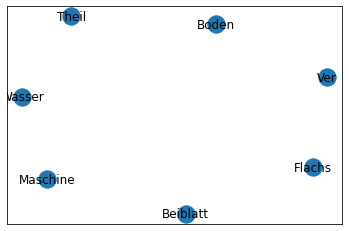

In [ ]:
import plotly.graph_objects as go

import networkx as nx

G = nx.DiGraph()

G.add_nodes_from(interesting_nouns)
nx.draw_networkx(G)

In [ ]:
cause_effect_rels = []

for noun in interesting_nouns:
# noun = "Erfolg"
    for i, sample in issue_results[issue_results["Cause_nouns"].apply(lambda l: noun in l)].iterrows():

        # print(i)
        for cause_noun in sample["Cause_nouns"]:
            for effect_noun in sample["Effect_nouns"]:

                if cause_noun in interesting_nouns and effect_noun in interesting_nouns:
                    G.add_edge(cause_noun, effect_noun)


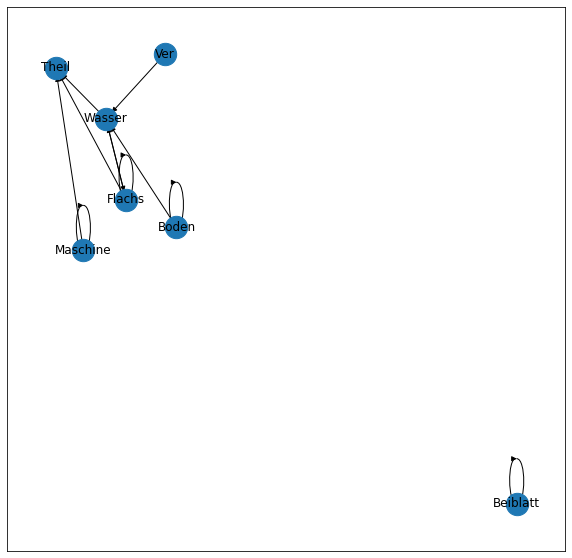

In [ ]:

plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, cmap=plt.get_cmap('jet'), node_size = 500)
nx.draw_networkx_labels(G, pos)
nx.draw_networkx_edges(G, pos, edgelist=G.edges(), arrows=True)
# nx.draw_networkx_edges(G, pos, edgelist=black_edges, arrows=False)
plt.show()

In [ ]:
G.nodes[edge[0]]

{}

In [ ]:
edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = G.nodes[edge[0]]['pos']
    x1, y1 = G.nodes[edge[1]]['pos']
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

node_x = []
node_y = []
for node in G.nodes():
    x, y = G.nodes[node]['pos']
    node_x.append(x)
    node_y.append(y)

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        # colorscale options
        #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
        #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
        #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
        colorscale='YlGnBu',
        reversescale=True,
        color=[],
        size=10,
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line_width=2))

KeyError: ignored

In [ ]:
node_adjacencies = []
node_text = []
for node, adjacencies in enumerate(G.adjacency()):
    node_adjacencies.append(len(adjacencies[1]))
    node_text.append('# of connections: '+str(len(adjacencies[1])))

node_trace.marker.color = node_adjacencies
node_trace.text = node_text

In [ ]:
fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='<br>Network graph made with Python',
                titlefont_size=16,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[ dict(
                    showarrow=False,
                    xref="paper", yref="paper",
                    x=0.005, y=-0.002 ) ],
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )
fig.show()